# TRY 2- ( FILTER NUMBERS STARTING FROM 32)
# Batch size -128
# target size - 32 x 32
# 30 EPOCHS
# Best loss 0.0051


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import time
from tensorflow.keras.utils import Sequence
%matplotlib inline

In [2]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [3]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),self.output_size)
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB),self.output_size)
#       print(img_path,img_path2)

      X[i,] = img
      Y[i,] = img2
    X= X.astype('float32')/255
    Y= Y.astype('float32')/255

    return X, Y

In [4]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img*255
    img=img.astype(np.uint)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [5]:
train = DataGenerator('data/train_x/train_x','data/train_y/train_y',(32,32), batch_size=128, shuffle=False)
test  = DataGenerator('data/test_x/test_x','data/test_y/test_y',(32,32), batch_size=128, shuffle=False)

In [11]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(32,32,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 32, 3)
   conv_block2 = conv_operation(conv_block1, 64, 3)
   conv_block3 = conv_operation(conv_block2, 128, 3)
   conv_block4 = conv_operation(conv_block3, 256, 3)
   
   conv_block5 = conv_operation(conv_block4, 256, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 256,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

#    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, final_deconv, name='dae')

In [12]:
model= deblurring_autoencoder()

In [13]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [14]:

callbacks=[
    ModelCheckpoint('deblur_my_shit.h5',verbose=1,save_best_only=True,save_weights_only=True)
]

In [21]:
model.fit(
    train,
    epochs=30,
    verbose=1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 78 steps
Epoch 1/10
78/78 [==============================] - 16s 205ms/step - loss: 0.0076 - mae: 0.0656
Epoch 2/10
78/78 [==============================] - 16s 205ms/step - loss: 0.0071 - mae: 0.0627
Epoch 3/10
78/78 [==============================] - 16s 207ms/step - loss: 0.0065 - mae: 0.0603
Epoch 4/10
78/78 [==============================] - 16s 208ms/step - loss: 0.0064 - mae: 0.0597
Epoch 5/10
78/78 [==============================] - 16s 209ms/step - loss: 0.0063 - mae: 0.0591
Epoch 6/10
78/78 [==============================] - 16s 211ms/step - loss: 0.0062 - mae: 0.0588
Epoch 7/10
78/78 [==============================] - 17s 213ms/step - loss: 0.0064 - mae: 0.0607
Epoch 8/10
78/78 [==============================] - 17s 213ms/step - loss: 0.0056 - mae: 0.0559
Epoch 9/10
78/78 [==============================] - 17s 217ms/step - loss: 0.0055 - mae: 0.0550
Epoch 10/10
78/78 [==============================] - 17s 213ms/step - loss: 0.0051 - mae: 0.

In [27]:
keras.models.save_model(
    model,'best_model'
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model\assets


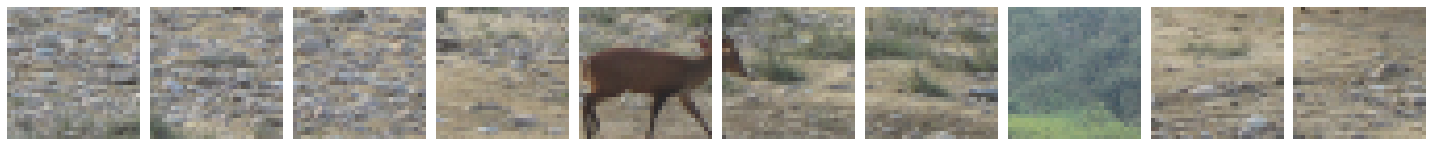

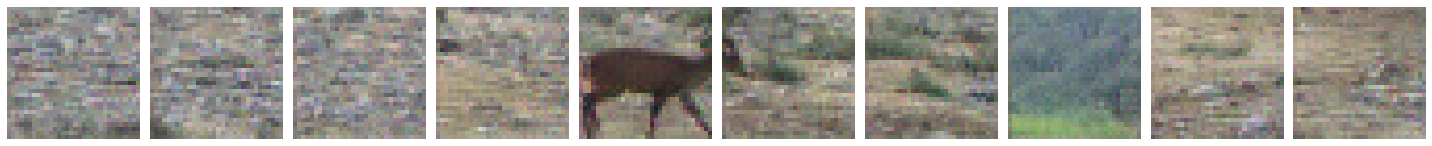

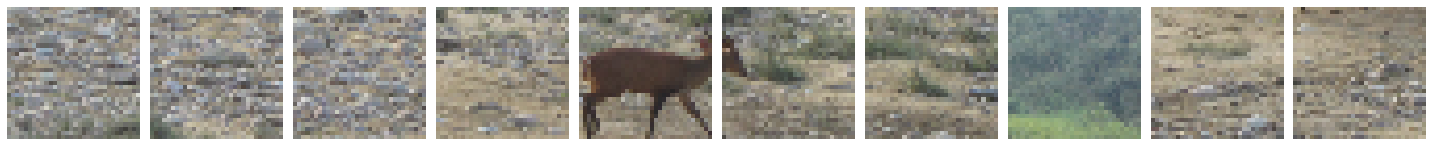

In [26]:
xx,yy=train[5]
prediction= model.predict(xx)
plotImages(xx)
plotImages(prediction)
plotImages(yy)